In [29]:
import os

import matplotlib.pyplot as plt
import pandas as pd
import numpy.typing as npt
import numpy as np
from tqdm import tqdm

In [30]:
dataset_for_intensity: dict[set[int, int], dict[str, npt.NDArray]] = {}
dataset_for_peak_shift: dict[set[int, int], dict[str, npt.NDArray]] = {}

In [31]:
run_n: int = 43
exp_id: str = 'ue_240607_FXS'
run_dir: str = f'/xfel/ffs/dat/{exp_id}/raw_data/h5/type=measurement/run={run_n:03}'

In [32]:
scan_dirs = [scan_dir for scan_dir in sorted(os.listdir(run_dir)) if scan_dir.startswith('scan=')]
scan_numbers = [int(scan_dir.replace('scan=', '')) for scan_dir in scan_dirs]
problem_scans = []
for scan_dir in tqdm(scan_dirs):
    scan_n = int(scan_dir.replace('scan=', ''))
    fnames = [os.path.join(run_dir, scan_dir, fname) for fname in sorted(os.listdir(os.path.join(run_dir, scan_dir)))]
    labels = dict(
        position_label = '',
        pump_event_label = 'event_info.RATE_HX_30HZ',
        # signal_label = 'pd:es:pd1:ch2',
        signal_label = 'detector:eh1:jungfrau2:ROI1_stat.sum',
        # signal_label = 'detector:eh1:jungfrau2:ROI2_stat.sum',
        # norm_label = 'pd:es:pd1:ch
        # norm_label = 'qbpm:oh:qbpm2:sum',
        norm_label = 'qbpm:eh1:qbpm1:sum',
        # norm_label = 'qbpm:eh1:qbpm2:sum',
        # norm_label = 'detector:eh1:jungfrau2:ROI2_stat.sum',
        
        # orm2_label = 'detector:eh1:jungfrau2:ROI7_stat.sum',
      # newsignal_label = 'detector:eh1:jungfrau2:ROI1_stat.sum'
    )
    
    positions = []
    signals_on = []
    signals_off = []
    ps_on = []
    ps_off = []
    sample_no_on = []
    sample_no_off = []
    norms_on = []
    norms_off = []
    signals_o_on = []
    signals_o_off = []
 
    for fname in tqdm(fnames[:], leave=True):
        df = pd.read_hdf(fname)
        
        if 'delay_input' in df.columns.values:
            labels['position_label'] = 'delay_input'
        elif 'laser_v_input' in df.columns.values:
            labels['position_label'] = 'laser_v_input'
        elif 'laser_h_input' in df.columns.values:
            labels['position_label'] = 'laser_h_input'
        elif 'th_input' in df.columns.values:
            labels['position_label'] = 'th_input'
        elif 'laser_fluence_percent_input' in df.columns.values:
            labels['position_label'] = 'laser_fluence_percent_input'
        elif 'phi_input' in df.columns.values:
            labels['position_label'] = 'phi_input'
        elif 'energy_input' in df.columns.values:
            labels['position_label'] = 'energy_input'
        elif 'dummy_input' in df.columns.values:
            labels['position_label'] = 'dummy_input'
        
        try:
            df_mini = df[labels.values()].dropna()
        except:
            psn = int(scan_dir.split('=')[1])
            problem_scans.append(psn)
            print('There was an error while reading scan=' + str(psn))
            continue
        
        position = df_mini[labels['position_label']].median()
        pump_event = df_mini[labels['pump_event_label']] == True
        
        #bkg_mean = (df_mini[labels['bkg_label']] - df_mini[labels['signal_label']]) / (df_mini[labels['roi2_area_label']] - df_mini[labels['roi1_area_label']])
        roi_sum = (
            df_mini[[
                labels['signal_label'],
            ]].values
            ).sum(axis=1)
        
        norm = df_mini[labels['norm_label']] #- bkg_mean*df_mini[labels['roi3_area_label']]

        norm_mask = np.logical_and(
            norm > norm.mean() - norm.std()*2,
            norm < norm.mean() + norm.std()*2,
        )
        norm_on = norm[norm_mask][pump_event[norm_mask]]
        norm_off = norm[norm_mask][pump_event[norm_mask] != True]
          
        signal_on = roi_sum[norm_mask][pump_event[norm_mask]] #- bkg_mean[pump_event] * df_mini[labels['roi1_area_label']][pump_event]
        signal_off = roi_sum[norm_mask][pump_event[norm_mask] != True] #- bkg_mean[pump_event != True] * df_mini[labels['roi1_area_label']][pump_event !=True]
               
        signal_ratio_on = signal_on / norm_on
        signal_ratio_off = signal_off / norm_off

        
        valid_on = np.logical_and(
            signal_ratio_on<signal_ratio_on.median() + signal_ratio_on.std()*.3, 
            signal_ratio_on>signal_ratio_on.median() - signal_ratio_on.std()*.3
            )
        valid_off = np.logical_and(
            signal_ratio_off<signal_ratio_off.median() + signal_ratio_off.std()*.3, 
            signal_ratio_off>signal_ratio_off.median() - signal_ratio_off.std()*.3
            )

        try:
            p_on = np.polyfit(norm_off, signal_off, 1)
            p_off = np.polyfit(norm_on, signal_on, 1)
        except:
            print('There was an error while reading p_on or p_off, ' + scan_dir)
            continue
        
    
        signal_norm_on = np.average(
            signal_on[valid_on] / norm_on[valid_on],
            weights = norm_on[valid_on]
            )
        signal_norm_off = np.average(
            signal_off[valid_off] / norm_off[valid_off],
            weights = norm_off[valid_off]
            )

        positions.append(position)
        signals_on.append(signal_norm_on)
        signals_off.append(signal_norm_off)
        #ps_on.append(p_on)
        #ps_off.append(p_off)
        sample_no_on.append(valid_on.size)
        sample_no_off.append(valid_off.size)

        signals_o_on.append(np.average(signal_on[valid_on]))
        signals_o_off.append(np.average(signal_off[valid_off]))
        norms_on.append(np.average(norm_on[valid_on]))
        norms_off.append(np.average(norm_off[valid_off]))
        
        
    positions = np.array(positions)
    signals_on = np.array(signals_on)
    signals_off = np.array(signals_off)
    signals_diff = (signals_on - signals_off)/signals_off
    #ps_on = np.array(ps_on)
    #ps_off = np.array(ps_off)
    signals_o_on = np.array(signals_o_on)
    signals_o_off = np.array(signals_o_off)
    norms_on = np.array(norms_on)
    norms_off = np.array(norms_off)
    
    dataset_for_intensity[(run_n, scan_n)] = {
        "labels": labels,
        "positions": positions,
        "signals_on": signals_on,
        "signals_off": signals_off,
        "signals_diff": signals_diff,
        "ps_on": ps_on,
        "ps_off": ps_off, 
        "sample_size_on": np.array(sample_no_on),
        "sample_size_off": np.array(sample_no_off),
    }

list(dataset_for_intensity.keys())

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:04<00:00,  4.92s/it]


[(43, 1)]

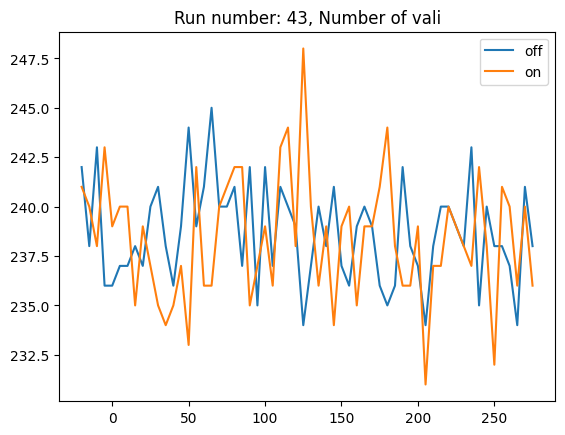

In [33]:
plt.figure()
plt.title(f"Run number: {run_n:}, Number of vali")
plt.plot(dataset_for_intensity[(run_n, scan_n)]["positions"], dataset_for_intensity[(run_n, scan_n)]["sample_size_off"], label = 'off')
plt.plot(dataset_for_intensity[(run_n, scan_n)]["positions"], dataset_for_intensity[(run_n, scan_n)]["sample_size_on"], label = 'on')
plt.legend();

In [34]:
for scan_dir in tqdm(scan_dirs):
    scan_n = int(scan_dir.replace('scan=', ''))
    fnames = [os.path.join(run_dir, scan_dir, fname) for fname in sorted(os.listdir(os.path.join(run_dir, scan_dir)))]

    labels = dict(
        position_label = 'laser_h_input',
        pump_event_label = 'event_info.RATE_HX_30HZ',
        signal_x_label = 'detector:eh1:jungfrau2:ROI1_stat.center_of_mass.x',
        # signal_x_label = 'detector:eh1:jungfrau2:ROI3_stat.center_of_mass.x',
        signal_y_label = 'detector:eh1:jungfrau2:ROI1_stat.center_of_mass.y',
        # signal_y_label = 'detector:eh1:jungfrau2:ROI3_stat.center_of_mass.y',
        # roi1_area_label = 'detector:eh1:jungfrau2:ROI2_stat.area',
        norm_label = 'qbpm:eh1:qbpm1:sum',
        # norm_label = 'qbpm:oh:qbpm2:sum',
    )

    positions = [];    signals_x_on = [];    signals_x_off = [];    signals_y_on = [];    signals_y_off = [];
    for fname in tqdm(fnames, leave=False):
        df = pd.read_hdf(fname)
        if 'delay_input' in df.columns.values:
            labels['position_label'] = 'delay_input'
        elif 'laser_v_input' in df.columns.values:
            labels['position_label'] = 'laser_v_input'
        elif 'laser_h_input' in df.columns.values:
            labels['position_label'] = 'laser_h_input'
        elif 'th_input' in df.columns.values:
            labels['position_label'] = 'th_input'
        elif 'laser_fluence_percent_input' in df.columns.values:
            labels['position_label'] = 'laser_fluence_percent_input'
        
        df_mini = df[labels.values()].dropna()
        position = df_mini[labels['position_label']].median()
        pump_event = df_mini[labels['pump_event_label']] == True
        COMx = df_mini[labels['signal_x_label']]
        COMy = df_mini[labels['signal_y_label']] # + 1000
        norm = df_mini[labels['norm_label']]

        norm_on = norm[pump_event] ;        norm_off = norm[pump_event != True]
        signal_x_on = COMx[pump_event] # - bkg_mean[pump_event] * df_mini[labels['roi1_area_label']][pump_event]
        signal_x_off = COMx[pump_event != True] # - bkg_mean[pump_event != True] * df_mini[labels['roi1_area_label']][pump_event !=True]
        signal_y_on = COMy[pump_event] # - bkg_mean[pump_event] * df_mini[labels['roi1_area_label']][pump_event]
        signal_y_off = COMy[pump_event != True] # - bkg_mean[pump_event != True] * df_mini[labels['roi1_area_label']][pump_event !=True]

        signal_x_norm_on = np.average(
            signal_x_on ,#/ norm_on,
            weights = norm_on        )
        signal_x_norm_off = np.average(
            signal_x_off ,#/ norm_off,
            weights = norm_off        )
        signal_y_norm_on = np.average(
            signal_y_on ,#/ norm_on,
            weights = norm_on        )
        signal_y_norm_off = np.average(
            signal_y_off ,#/ norm_off,
            weights = norm_off        )

        positions.append(position)
        signals_x_on.append(signal_x_norm_on)
        signals_x_off.append(signal_x_norm_off)
        signals_y_on.append(signal_y_norm_on)
        signals_y_off.append(signal_y_norm_off)

    positions = np.array(positions)
    signals_x_on = np.array(signals_x_on)
    signals_x_off = np.array(signals_x_off)
    signals_y_on = np.array(signals_y_on)
    signals_y_off = np.array(signals_y_off)
    signals_x_diff = (signals_x_off - signals_x_on)
    signals_y_diff = (signals_y_off - signals_y_on)

    dataset_for_peak_shift[(run_n, scan_n)] = {
        "labels": labels,  
        "positions": positions,
        "signals_x_on": signals_x_on,
        "signals_x_off": signals_x_off,
        "signals_x_diff": signals_x_diff,
        "signals_y_on": signals_y_on,
        "signals_y_off": signals_y_off,
        "signals_y_diff": signals_y_diff,
    }

100%|██████████| 1/1 [00:03<00:00,  3.20s/it]


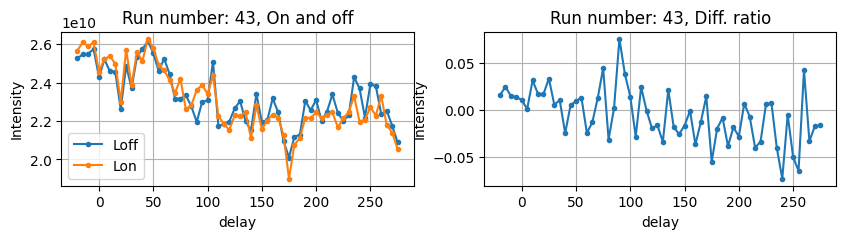

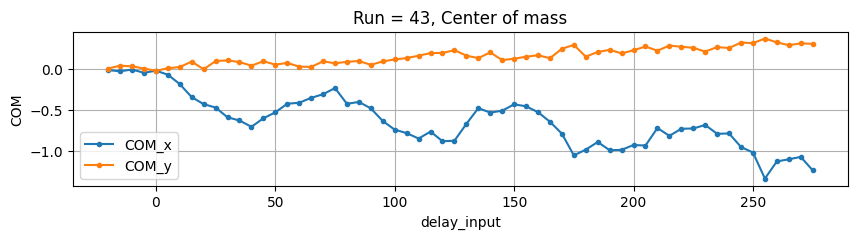

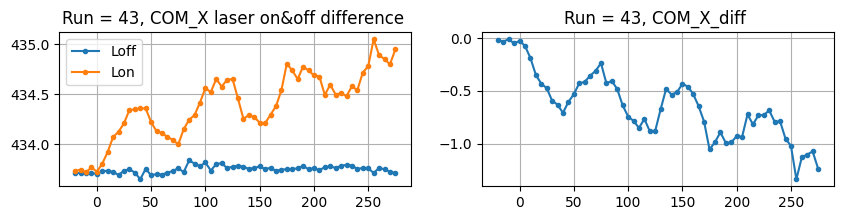

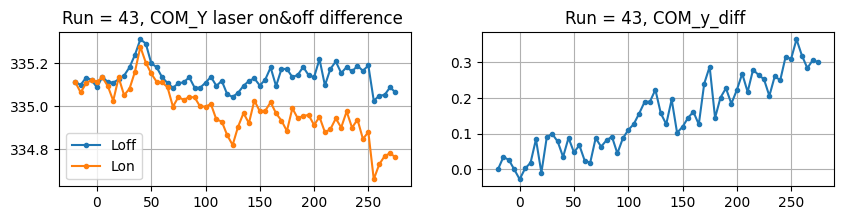

In [35]:
plt.figure(20,figsize=(10,2))
plt.subplot(1,2, 1)
plt.title(f"Run number: {run_n:}, On and off")
plt.plot(dataset_for_intensity[(run_n, scan_n)]["positions"], dataset_for_intensity[(run_n, scan_n)]["signals_off"], '.-')
plt.plot(dataset_for_intensity[(run_n, scan_n)]["positions"], dataset_for_intensity[(run_n, scan_n)]["signals_on"], '.-')

plt.legend(['Loff', 'Lon']);plt.grid();plt.ylabel('Intensity');plt.xlabel('delay')
plt.subplot(1,2, 2)
plt.title(f"Run number: {run_n:}, Diff. ratio")
plt.plot(dataset_for_intensity[(run_n, scan_n)]["positions"], dataset_for_intensity[(run_n, scan_n)]["signals_diff"], '.-')
plt.grid();plt.ylabel('Intensity');plt.xlabel('delay')

plt.figure(6,figsize=(10,2))
plt.plot(dataset_for_peak_shift[(run_n, scan_n)]["positions"], dataset_for_peak_shift[(run_n, scan_n)]["signals_x_diff"], '.-')
plt.plot(dataset_for_peak_shift[(run_n, scan_n)]["positions"], dataset_for_peak_shift[(run_n, scan_n)]["signals_y_diff"], '.-')
plt.xlabel(labels['position_label'])
plt.ylabel('COM')
plt.legend(['COM_x','COM_y'])
plt.title(f'Run = {run_n}, Center of mass')
plt.grid()

plt.figure(7,figsize=(10,2))
plt.subplot(1, 2, 1)
plt.plot(dataset_for_peak_shift[(run_n, scan_n)]["positions"], dataset_for_peak_shift[(run_n, scan_n)]["signals_x_off"], '.-')
plt.plot(dataset_for_peak_shift[(run_n, scan_n)]["positions"], dataset_for_peak_shift[(run_n, scan_n)]["signals_x_on"], '.-')
plt.title(f'Run = {run_n}, COM_X laser on&off difference ')
plt.legend(['Loff', 'Lon'])
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(dataset_for_peak_shift[(run_n, scan_n)]["positions"], dataset_for_peak_shift[(run_n, scan_n)]["signals_x_diff"], '.-')
plt.title(f'Run = {run_n}, COM_X_diff ')
plt.grid()

plt.figure(8,figsize=(10,2))
plt.subplot(1, 2, 1)
plt.plot(dataset_for_peak_shift[(run_n, scan_n)]["positions"], dataset_for_peak_shift[(run_n, scan_n)]["signals_y_off"], '.-')
plt.plot(dataset_for_peak_shift[(run_n, scan_n)]["positions"], dataset_for_peak_shift[(run_n, scan_n)]["signals_y_on"], '.-')
plt.title(f'Run = {run_n}, COM_Y laser on&off difference ')
plt.legend(['Loff', 'Lon'])
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(dataset_for_peak_shift[(run_n, scan_n)]["positions"], dataset_for_peak_shift[(run_n, scan_n)]["signals_y_diff"], '.-')
plt.title(f'Run = {run_n}, COM_y_diff ')
plt.grid();

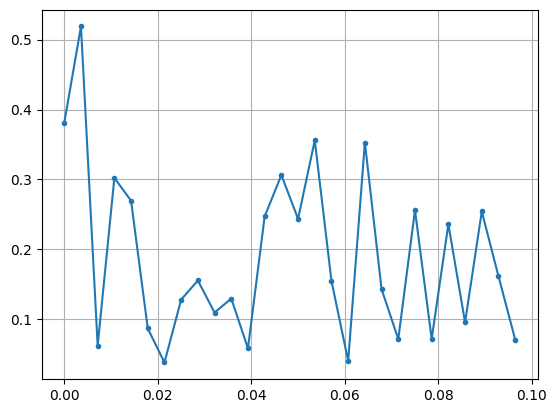

In [36]:
x = dataset_for_intensity[(run_n, scan_n)]["positions"]
y = dataset_for_intensity[(run_n, scan_n)]["signals_diff"]
t0 = -1
N = x[x>t0].shape[0]
T = x[1]-x[0]
yf = np.fft.fft(y[x>t0])
xf = np.fft.fftfreq(N,T)[:N//2]
plt.plot(xf, np.abs(yf[0:N//2]), '.-')
plt.grid()

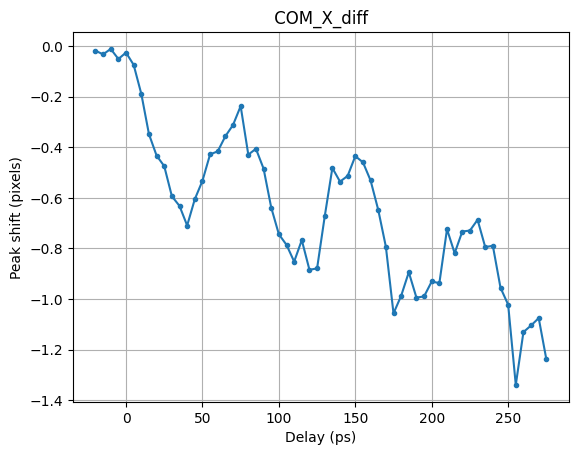

In [37]:
plt.plot(dataset_for_peak_shift[(run_n, scan_n)]["positions"], dataset_for_peak_shift[(run_n, scan_n)]["signals_x_diff"], '.-')
# plt.axhline(y=0, color='k', linestyle='-')
plt.title(f' COM_X_diff ')
plt.ylabel('Peak shift (pixels)')
plt.xlabel('Delay (ps)')
plt.grid()

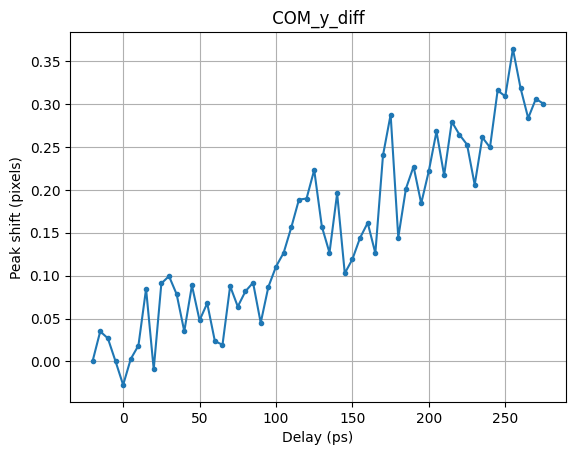

In [38]:
plt.plot(dataset_for_peak_shift[(run_n, scan_n)]["positions"], dataset_for_peak_shift[(run_n, scan_n)]["signals_y_diff"], '.-')
# plt.axhline(y=0, color='k', linestyle='-')
plt.title(f' COM_y_diff ')
plt.ylabel('Peak shift (pixels)')
plt.xlabel('Delay (ps)')
plt.grid()